In [1]:
#The required packages 
import numpy as np
import pandas as pd

from scipy.stats import beta
from scipy.stats import gamma

import matplotlib.pyplot as plt

In [2]:
#Function for selecting price from a price scheme for each sample.

# We assumed the last entrant always gets only half the expected market share. So if we have n-1 entry, the nth firm's 
# market share will be B/(2n) and it will enter if its profit, pi=p(n)-C-((2n*F)/B), is bigger of equal to zero. 
# The first price in each price scheme is 1, so this function set the price equal 1 for zero entry.

def FPS(b,c,f,scheme):
    d=len(b) #Number of samples
    scheme = scheme[~np.isnan(scheme)] #Delete NaN value from the scheme
    Ls=len(scheme) #length of the price scheme
    
    Ns=np.zeros(d) #Number of entry for each sample
    Ps=np.ones(d) #Selected price for each sample

    for i in range(d):
        n=0 
        pn=scheme[0] 
        pn1=scheme[1] #price of the next entry
        pi=pn1-c[i]-((f[i])/b[i]) #profit of the first entry. 
        
        while (0<= pi):
            n=n+1 #Number of entries
            pn=pn1 #Price when we have n entries
            
            if (n+1) < Ls:
                pn1=scheme[n+1]
            else:
                pn1=scheme[Ls-1]
                
            pi=pn1-c[i]-((2*(n+1)*f[i])/b[i]) #profit of the next entry.
        
        Ns[i]=n
        Ps[i]=pn 

    return Ns,Ps

In [3]:
#Set up the parameters

B_shape, B_scale = 1.5, 10000000 #gamma function for B large country
b_shape, b_scale = 1.5, 2000000 #gamma function for B small country
C_alpha, C_beta = 1.3, 5 #beta function for C
F_min,F_max=30000, 500000 #min and max of the fixed cost

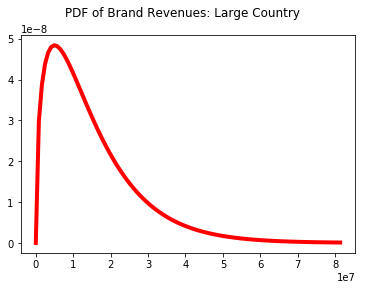

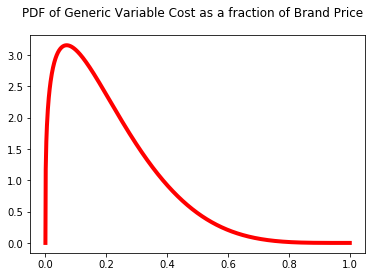

In [4]:
#Plot the probability distributions

#Plot the probability distribution for B
fig, ax = plt.subplots(1, 1)
x = np.linspace(gamma.ppf(0, B_shape, scale=B_scale), gamma.ppf(0.999, B_shape, scale=B_scale), 100)
plt.suptitle('PDF of Brand Revenues: Large Country', fontsize=12)
ax.plot(x, gamma.pdf(x, B_shape, scale=B_scale),'r-', lw=4, alpha=1, label='gamma pdf')
fig.savefig('Brand_Revenues.png')

#Plot the probability distribution for C
fig, ax = plt.subplots(1, 1)
x = np.linspace(beta.ppf(0, C_alpha, C_beta), beta.ppf(1, C_alpha, C_beta), 1000)
plt.suptitle('PDF of Generic Variable Cost as a fraction of Brand Price', fontsize=12)
ax.plot(x, beta.pdf(x, C_alpha, C_beta),'r-', lw=4, alpha=1, label='beta pdf')
fig.savefig('Generic_Variable_Cost.png')

In [5]:
#Random draw for each of the main variables

D=10000 #Number of samples
B = np.random.gamma(B_shape, B_scale, D) #Brand market size for large countries
b = np.random.gamma(b_shape, b_scale, D) #Brand market size for small countries
C = np.random.beta(C_alpha, C_beta, D) #Generic variable cost
F = np.random.uniform( F_min, F_max, D) #Generic entry cost, per year

In [6]:
MP=C+(F/B) #Minimum price for one entry for large countries. 

Mp=C+(F/b) #Minimum price for one entry for small countries. 


#Set prices equal to one if they are bigger than one. 

MP=np.clip(MP, 0, 1) 

Mp=np.clip(Mp, 0, 1) 

AMP=np.mean(MP) #Average minimum prices for large countries

AMp=np.mean(Mp) #Average minimum prices for large countries

In [7]:
Schemes = pd.read_excel('Tiers.xlsx',header=0) #reading price scheme from the excel file

columns = pd.Index(['AMP','WAP', 'ACE', 'AGP','ANE','ShBP'])
index = pd.Index(Schemes.columns, name="Model")

Tab_L = pd.DataFrame(index=index, columns=columns) # define the result table for large countries
Tab_S = pd.DataFrame(index=index, columns=columns) # define the result table for small countries

In [8]:
#Calculating the Results for large countries

for Sch in Schemes.columns:
    NS,PS=FPS(B,C,F,Schemes[Sch]) #Sheme price and number of entry for each sample
    Tab_L.loc[Sch]['AMP']=AMP #Average minimum price
    Tab_L.loc[Sch]['WAP']=np.sum(B*PS)/np.sum(B) #Weighted average Price
    Tab_L.loc[Sch]['ACE']=np.sum(F*NS)/np.sum(B) #Average cost of entry
    Tab_L.loc[Sch]['AGP']=np.sum((B*(PS-C))-(F*NS))/np.sum(B) #Average profit
    Tab_L.loc[Sch]['ANE']=np.mean(NS) #Average number of entry 
    
    SP=np.sum((B*(PS-C))-(F*NS)) #Sum of profit
    
    #Variables for monopoly cases
    BM=B[NS==0]
    CM=C[NS==0]
    PSM=PS[NS==0]
    
    SBP=np.sum((BM*(PSM-CM))) #Sum of brand profit
    
    Tab_L.loc[Sch]['ShBP']=SBP/SP #Share of brand profit 
    
Tab_L.columns=['Average minimum price','Weighted average Price','Average cost of entry','Average profit','Average number of entry', 'Share of brand profit'] # Changing the name of columns
Tab_L.to_excel("Table(Large Countries).xlsx") #Saving the results into a exel file

In [9]:
#Calculating the Results for small countries

for Sch in Schemes.columns:
    NS,PS=FPS(b,C,F,Schemes[Sch]) #Sheme price and number of entry for each sample
    Tab_L.loc[Sch]['AMP']=AMp #Average minimum price
    Tab_S.loc[Sch]['WAP']=np.sum(b*PS)/np.sum(b) #Weighted average Price
    Tab_S.loc[Sch]['ACE']=np.sum(F*NS)/np.sum(b) #Average cost of entry
    Tab_S.loc[Sch]['AGP']=np.sum((b*(PS-C))-(F*NS))/np.sum(b) #Average generic profit
    Tab_L.loc[Sch]['ANE']=np.mean(NS) #Average number of entry 
    
    SP=np.sum((b*(PS-C))-(F*NS)) #Sum of profit
    
    #Variables for monopoly cases
    bM=b[NS==0]
    CM=C[NS==0]
    PSM=PS[NS==0]
    
    SBP=np.sum((bM*(PSM-CM))) #Sum of brand profit
    
    Tab_L.loc[Sch]['ShBP']=SBP/SP #Share of brand profit 
    
Tab_L.columns=['Average minimum price','Weighted average Price','Average cost of entry','Average profit','Average number of entry', 'Share of brand profit'] # Changing the name of columns
Tab_S.to_excel("Table(Small Countries).xlsx") #Saving the results into a exel file